<br>

## __Exercício: Detecção de Anomalias__

<br>

__1:__

Utilizando a classe DetectorAnomalias criada ao longo do módulo, __vamos avaliar um detector de anomalias.__

O dataset utilizado pode ser importado através da função getData. 

Nesse conjunto de dados, possuímos 6 variáveis explicativas, $X_1, .., X_6$ e uma variável com a marcação se a instância é uma anomalia ou não.

Utilizando a __metodolodia__ discutida ao longo do módulo, __teste diferentes modelos (variando o limiar $\epsilon$)__ a fim de encontrar o que __melhor fita os dados.__

Justifique as escolhas do $\epsilon$, bem como quais as métricas de performance abordadas. 

In [1]:
import pandas as pd 
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

In [2]:
class DetectorAnomalias():
    
    def __init__(self, epsilon):
        self.epsilon = epsilon
        
    def fit(self, X):
        medias = X.mean(axis = 0)
        desvios = X.std(axis = 0)
        gaussianas = [st.norm(loc = m, scale = d) for m, d in zip(medias, desvios)]  
        self.gaussianas = gaussianas
        self.X = X
        
    def prob(self, x):
        p = 1
        for i in range(self.X.shape[1]):
            gaussiana_i = self.gaussianas[i]
            x_i = x[i]
            p *= gaussiana_i.pdf(x_i)
        return p
    
    def isAnomaly(self, x):
        return int(np.where(self.prob(x) < self.epsilon, 1, 0))

In [3]:
def getData():
    return pd.read_csv("dataframe_anomalias_exercicio.csv")

In [4]:
df = getData()
df

,x1,x2,x3,x4,x5,x6,anomalia
0,7.731153,23.299155,-0.367453,4.715372,9.306179,16.780965,0.0
1,11.466833,16.943695,-0.245131,7.060311,10.462826,19.821289,0.0
2,11.501272,20.196011,1.206049,-4.957189,7.771262,19.100079,0.0
3,10.893921,16.072385,2.738045,-3.684228,7.373334,23.225524,0.0
4,10.091706,19.253894,0.996895,-9.504052,8.883988,17.903298,0.0
...,...,...,...,...,...,...,...
10095,11.192286,18.451987,-0.953650,-14.362996,10.875826,17.056541,0.0
10096,12.014177,19.461815,1.985099,-7.119190,11.079922,17.582755,0.0
10097,10.745460,18.175951,0.206037,-1.897015,9.888329,17.963324,0.0
10098,9.893969,22.333270,-1.465981,4.137382,7.690620,21.570097,0.0


In [5]:
df.anomalia.value_counts()

0.0    10046
1.0       54
Name: anomalia, dtype: int64

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

Primeiramente faremos uma abordagem de aprendizado não-supervisionado para detecção de anomalias. Vamos separar o dataset em treino, validação e teste, nas proporções de 60% / 20% / 20%, sendo que o dataset de teste será composto somente de instâncias não-anômalas. Os datasets de validação e teste dividirão por igual as instâncias anômalas

In [7]:
# obtendo o dataset de treino, utilizando somente as entradas não-anômalas (classe negativa)

df_train, _ = train_test_split (df[df.anomalia==0], train_size=0.6, random_state=0)

In [8]:
Xtrain = df_train.iloc[:,:6].values

In [9]:
# criando um subdataset a partir do original, eliminando as instâncias já selecionadas para treino
dff = df.drop(index = df_train.index)

In [10]:
# o subdataset será dividido por igual entre validação e teste, mantendo a mesma quantidade proporcional
# de instâncias de classe positiva
df_val, df_test = train_test_split(dff, train_size = 0.5, stratify = dff.anomalia, random_state=0)

In [11]:
Xval = df_val.values

In [12]:
Xtest = df_test.values

In [13]:
from time import time

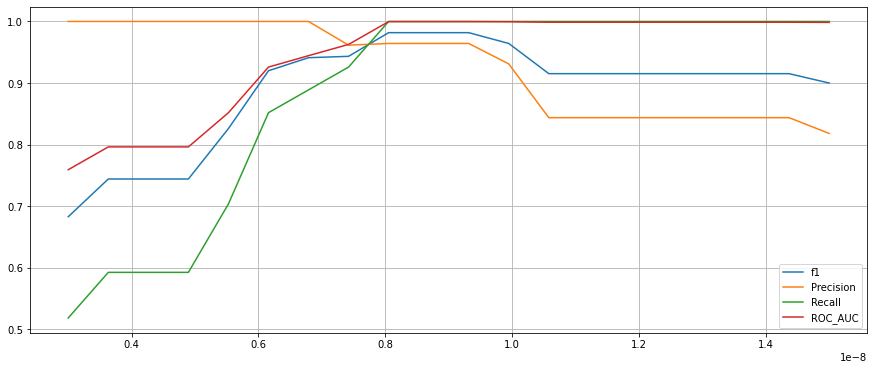

In [14]:
# este bloco obterá e plotará um gráfico com as métricas obtidas de várias instâncias da classe definida no início do código.
# O objetivo é encontrar uma faixa de valores mais adequados para o limiar 'epsilon' , probailidade máxima para que uma
# instância seja admitida sob a combinação das gaussianas específicas deste problema.

lista_f1, lista_precision, lista_recall, lista_roc_auc=[],[],[],[]

lista_eps=np.linspace(0.000000003, 0.000000015,20)
for e in lista_eps:
    ann = DetectorAnomalias(epsilon = e)
    ann.fit(Xtrain)
    anomalias = [ann.isAnomaly(i[:6]) for i in Xval]
    lista_f1.append(f1_score(y_true = Xval[:,6], y_pred = anomalias))
    lista_precision.append(precision_score(y_true = Xval[:,6], y_pred = anomalias))
    lista_recall.append(recall_score(y_true = Xval[:,6], y_pred = anomalias))
    lista_roc_auc.append(roc_auc_score(y_true = Xval[:,6], y_score = anomalias))
    
plt.figure(figsize=[15,6])
plt.plot(lista_eps, lista_f1, label='f1')
plt.plot(lista_eps, lista_precision, label = 'Precision')
plt.plot(lista_eps, lista_recall, label = 'Recall')
plt.plot(lista_eps, lista_roc_auc, label = 'ROC_AUC')
plt.legend()
plt.grid()
plt.show()

Em se tratando de um problema de detecção de anomalias, supomos que devemos priorizar a minimização, e se possível a eliminação de falsos negativos, mesmo que possam resultar em alguns falsos positivos. Entendemos que é muito mais problemática a não-detecção de uma anomalia do que uma suspeita de anomalia que pode ser analisade de forma mais detalhada ou mesmo manualmente.

Sendo assim, a métrica Recall poderia ser privilegiada. No gráfico, observamos que a partir de um determinado limiar, Recall será sempre 1 (ótimo). Vamos adotar um valor que maximize ambos Recall e Precision. A métrica que melhor retrata este trade-off é a ROC_AUC (também poderia ser F1).

A convergência de valores se dá para um limiar ao redor de 8x10<sup>-9</sup>

In [15]:
t0 = time()

ann = DetectorAnomalias(epsilon = 0.0000000083)
ann.fit(Xtrain)
anomalias = [ann.isAnomaly(i[:6]) for i in Xval]

t1 = time()

print ("Total instâncias validação: ", df_val.shape[0])
print ("Acurácia   : ", round(accuracy_score(y_true = Xval[:,6], y_pred = anomalias),4))
print ("Recall     : ", round(recall_score(y_true = Xval[:,6], y_pred = anomalias),4))
print ("Precision  : ", round(precision_score(y_true = Xval[:,6], y_pred = anomalias),4))
print ("F1         : ", round(f1_score(y_true = Xval[:,6], y_pred = anomalias),4))
print ("ROC_AUC    : ", round(roc_auc_score(y_true = Xval[:,6], y_score = anomalias),4))
print (confusion_matrix(y_true = Xval[:,6], y_pred = anomalias))
print ('Tempo decorrido: ', round((t1-t0),2), ' segundos')

Total instâncias validação:  2036
Acurácia   :  0.9995
Recall     :  1.0
Precision  :  0.9643
F1         :  0.9818
ROC_AUC    :  0.9998
[[2008    1]
 [   0   27]]
Tempo decorrido:  0.94  segundos


O resultado obtido na validação é bom. Recall e ROC_AUC são altos e temos somente uma ocorrência de falso positivo.

O valor de epsilon adotado é 8,3x10<sup>-9</sup>. Vamos rodar com o dataset de teste:

In [16]:
ann = DetectorAnomalias(epsilon = 0.0000000083)
ann.fit(Xtrain)
anomalias = [ann.isAnomaly(i[:6]) for i in Xtest]
print ("Total instâncias validação: ", df_test.shape[0])
print ("Acurácia   : ", round(accuracy_score(y_true = Xtest[:,6], y_pred = anomalias),4))
print ("Recall     : ", round(recall_score(y_true = Xtest[:,6], y_pred = anomalias),4))
print ("Precision  : ", round(precision_score(y_true = Xtest[:,6], y_pred = anomalias),4))
print ("F1         : ", round(f1_score(y_true = Xtest[:,6], y_pred = anomalias),4))
print ("ROC_AUC    : ", round(roc_auc_score(y_true = Xtest[:,6], y_score = anomalias),4))
print (confusion_matrix(y_true = Xtest[:,6], y_pred = anomalias))

Total instâncias validação:  2037
Acurácia   :  1.0
Recall     :  1.0
Precision  :  1.0
F1         :  1.0
ROC_AUC    :  1.0
[[2010    0]
 [   0   27]]


O modelo detectou todas as anomalias e não retornou falsos positivos nem negativos.

<br>

__2:__ 

Aborde o problema num contexto de aprendizado supervisionado, ou seja, treine modelos de classificação binária com o objetivo de detectar anomalias.

Compare os resultados entre as metodologias.

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [18]:
# faremos novos datasets de treino e test, agora na proporção 80/20 e mantendo ambos com quantidades proporcionais de
# instâncias anômalas
df_train1, df_test1 = train_test_split (df, train_size = 0.8, stratify = df.anomalia, random_state=0)

In [19]:
Xtrain1 = df_train1.iloc[:,:6].values
ytrain1 = df_train1.iloc[:,6].values
Xtest1 = df_test1.iloc[:,:6].values
ytest1 = df_test1.iloc[:,6].values

Vamos testar alguns algoritmos de classificação utilizando o GridSearch para avaliar melhores parãmetros em alguns deles. Adotaremos a ROC_AUC como métrica:

In [20]:
# testando a regressão logística com validação cruzada

metricas_reglog = cross_val_score (estimator = LogisticRegression(), X=Xtrain1, y=ytrain1, scoring = 'roc_auc', cv=7)
print ('REGRESSÃO LOGÍSTICA')
print ('Média ROC_AUC em treino/validação: ', round(np.mean(metricas_reglog),4))
print ('Desvio padrão: ', round(np.std(metricas_reglog),4))

REGRESSÃO LOGÍSTICA
Média ROC_AUC em treino/validação:  0.5975
Desvio padrão:  0.0892


In [21]:
# KNearestNeighbors

params_KNN = {'n_neighbors':[10,100,200,1000,2000,5000,6000]}
grid_KNN = GridSearchCV (estimator = KNeighborsClassifier(), param_grid = params_KNN, scoring = 'roc_auc', cv = 5)
grid_KNN.fit(Xtrain1, ytrain1)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [10, 100, 200, 1000, 2000, 5000, 6000]},
             scoring='roc_auc')

In [22]:
results_KNN = pd.DataFrame(grid_KNN.cv_results_)
results_KNN[['params','mean_test_score']]

,params,mean_test_score
0,{'n_neighbors': 10},0.629043
1,{'n_neighbors': 100},0.759662
2,{'n_neighbors': 200},0.787440
3,{'n_neighbors': 1000},0.885592
4,{'n_neighbors': 2000},0.873791
5,{'n_neighbors': 5000},0.790223
6,{'n_neighbors': 6000},0.718124


In [23]:
# Árvore de classificaçáo

params_DT = {'max_depth':[2,5,10,50,100,200]}
grid_DT = GridSearchCV (estimator = DecisionTreeClassifier(), param_grid = params_DT, scoring = 'roc_auc', cv = 5)
grid_DT.fit(Xtrain1, ytrain1)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 5, 10, 50, 100, 200]},
             scoring='roc_auc')

In [24]:
results_DT = pd.DataFrame(grid_DT.cv_results_)
results_DT[['params','mean_test_score']]

,params,mean_test_score
0,{'max_depth': 2},0.523549
1,{'max_depth': 5},0.537559
2,{'max_depth': 10},0.580962
3,{'max_depth': 50},0.641625
4,{'max_depth': 100},0.687396
5,{'max_depth': 200},0.652860


In [25]:
# Random Forest
params_RF = {'n_estimators':[10,50,500,1000,5000]}
grid_RF = GridSearchCV (estimator = RandomForestClassifier(), param_grid = params_RF, scoring = 'roc_auc', cv = 5)
grid_RF.fit(Xtrain1, ytrain1)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'n_estimators': [10, 50, 500, 1000, 5000]},
             scoring='roc_auc')

In [26]:
results_RF= pd.DataFrame(grid_RF.cv_results_)
results_RF[['params','mean_test_score','mean_fit_time']]

,params,mean_test_score,mean_fit_time
0,{'n_estimators': 10},0.846062,0.113434
1,{'n_estimators': 50},0.945083,0.580286
2,{'n_estimators': 500},0.987773,5.913932
3,{'n_estimators': 1000},0.964992,12.522696
4,{'n_estimators': 5000},0.985166,64.721500


Resultados:

De um modo geral a abordagem supervisionada teve performance inferior à da abordagem não-supervisionada.

Os melhores resultados de cada modelo supervisionados foram:

Regressão Logística: 0,59
KNN: 0,88
Decision Tree: 0,67

Dos modelos testados, o Random Forest obteve um resultado próximo à abordagem não-supervisionada. O modelo com 5.000 estimadores resultou num score médio de aprox. 0,98 (no método não-supervisionado obtivemos 0,99). No entanto, o tempo de processamento ficou substancialmente mais alto (55s ante 1,17s).

Podemos afirmar que, no contexto dos dados estudados e com os modelos testados, a abordagem não-supervisionada foi mais eficaz e a causa mais provável é que a pouca quantidade de instãncias com anomalias (54 de um total de 10.100) não são suficientes para treinar os modelos em identificar os padrões.